# Clustering with M3GNet features

Node and edge features are used to represent atoms and bonds respectively.

Each structure is represented as a graph, with an atom being a node and a bond (between "neighbouring" atoms) being an edge. These features are extracted for each structure. Note that there are more than one feature per structure, since the number of node features is equal to the number of atoms, whereas the number of bond features is equal ti the number of bonds. These are stored in pandas DataFrames, and clustered into three clusters. Following PCA, features are plotted in lower-deimensionality space using the first two principle components. Clusters are shown, along with the space groups of the features' associated structure.

In [2]:
from __future__ import annotations

import warnings

from pymatgen.core import Lattice, Structure
from pymatgen.io.ase import AseAtomsAdaptor

import matgl
from matgl.ext.ase import Atoms2Graph
import parser

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import os
import time
from ase import Atoms
from ase.io import write

## Compute the graph data

In [3]:
# Read in the structure with the parser and outpute and ase atoms object (no longer a pymatgen Structure).

def create_struc(filename):
    s = parser.CIFParser(filename)
    a,b,c,alpha,beta,gamma = s.lattice_parameters[:]
    lattice = Lattice.from_parameters(a,b,c,alpha,beta,gamma)
    atomic_positions = []
    elements = []
    for key in s.unique_positions:
        for i in range(len(s.unique_positions[key])):
            elements.append(key)
            atomic_positions.append(s.unique_positions[key][i])
    return Structure(lattice, elements, atomic_positions, coords_are_cartesian=False).to_ase_atoms()

In [4]:
# Load M3GNet
pot = matgl.load_model("M3GNet-MP-2021.2.8-PES")
# Save the model's standard cut-off
rcut = pot.model.cutoff

In [6]:
# Find the filenames
directory_path = os.path.join("CIF") 
cif_files = [os.path.join(directory_path,file) for file in os.listdir(directory_path) if file.endswith(".cif")]

In [8]:
# Collect the graphs and the atoms object for each structure.

# Dictionary containing the graphs for each system
d_graph = {}

for filename in cif_files:
    
    name = filename.split('/')[1].split('.')[0]
    print(name)
    
    # Load the structure as an atoms object.
    atoms = create_struc(filename)
    # List of unique species, required to define the graph
    species=list(set(atoms.get_chemical_symbols()))
    
    # Create the graph of the model
    g,u = Atoms2Graph(species, rcut).get_graph(atoms)
    # Pass the graph through message-passing network
    pot.model(g,u)
    
    # Store the graph
    d_graph[name] = g,atoms

group-18_CollCode194747
group-14-4_CollCode14593
group-14-4_CollCode22693
group-16_CollCode15910
group-16_CollCode9868_mod
group-16_CollCode240086_mod
group-14-4_CollCode5301_mod
group-16_CollCode80164
group-18_CollCode39248
group-16_CollCode88766
group-18_CollCode64937_mod
group-18_CollCode64939
group-16_CollCode240084_mod
group-14-4_CollCode21535
group-18_CollCode163980
group-14-2_CollCode13560
group-18_CollCode244749
group-18_CollCode60570


## Parse the node and edge features

In [9]:
# Create the empty pandas DataFrame for the node features.
columns = ["System","Space Group","Species"]
columns.extend([f"Atom Feature {i+1}" for i in range(64)])

# Total number of nodes.
node_count = sum([g[0].num_nodes() for g in d_graph.values()])

# Initialise empty pandas DataFrame.
pd_node = pd.DataFrame(columns=columns,index=range(node_count))

In [10]:
count = 0

# Iterate over the different graphs.
for name in d_graph:
    
    # Extract the features.
    features=d_graph[name][0].ndata['node_feat'].detach().numpy()
    mask = slice(count,count+len(features))
    
    # Name of system column
    pd_node.iloc[mask,0] = [name for i in range(len(features))]
    # Space Group column
    pd_node.iloc[mask,1] = [int(name.split("-")[1].split("_")[0]) for i in range(len(features))]
    # Species column
    pd_node.iloc[mask,2] = d_graph[name][1].get_chemical_symbols()
    # Node features
    pd_node.iloc[mask,3:] = features
    
    count += len(features)

In [11]:
# DataFrame for node features
pd_node

,System,Space Group,Species,Atom Feature 1,Atom Feature 2,Atom Feature 3,Atom Feature 4,Atom Feature 5,Atom Feature 6,Atom Feature 7,...,Atom Feature 55,Atom Feature 56,Atom Feature 57,Atom Feature 58,Atom Feature 59,Atom Feature 60,Atom Feature 61,Atom Feature 62,Atom Feature 63,Atom Feature 64
0,group-18_CollCode194747,18,C,0.126048,-0.180444,-0.384504,0.151815,-0.841144,0.466713,0.493861,...,-0.241127,-0.646418,0.190382,-0.496134,-0.242084,-0.031037,0.618624,-0.17952,-0.030956,-0.157627
1,group-18_CollCode194747,18,C,0.126048,-0.180444,-0.384504,0.151816,-0.841143,0.466713,0.493861,...,-0.241127,-0.646418,0.190382,-0.496134,-0.242084,-0.031037,0.618623,-0.17952,-0.030956,-0.157627
2,group-18_CollCode194747,18,C,0.153623,-0.201933,-0.394511,0.216118,-1.021094,0.506009,0.4822,...,-0.229755,-0.545471,0.214048,-0.434809,-0.307053,-0.046691,0.515827,-0.124703,0.053125,-0.203053
3,group-18_CollCode194747,18,C,0.153623,-0.201933,-0.39451,0.216117,-1.021094,0.506009,0.4822,...,-0.229756,-0.545471,0.214048,-0.434809,-0.307053,-0.046691,0.515828,-0.124702,0.053125,-0.203053
4,group-18_CollCode194747,18,C,0.165705,-0.168101,-0.385538,0.221688,-0.845325,0.495572,0.501061,...,-0.241164,-0.601064,0.207925,-0.504701,-0.259867,-0.043007,0.472381,-0.121762,-0.020113,-0.19094
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1035,group-18_CollCode244749,18,S,0.054991,-0.078232,0.071778,-0.432002,-0.189291,0.043175,-0.098338,...,0.09137,0.028696,0.372682,0.142002,-0.401103,0.012043,-0.15057,0.316799,-0.114439,0.18171
1036,group-18_CollCode60570,18,Cd,0.137819,-0.143898,-0.064568,0.004886,-0.263124,0.360785,-0.053126,...,-0.090135,-0.49419,0.246543,-0.331917,-0.402383,-0.061166,0.129745,-0.155734,-0.016504,-0.170997
1037,group-18_CollCode60570,18,Cd,0.137819,-0.143898,-0.064568,0.004886,-0.263124,0.360785,-0.053126,...,-0.090135,-0.49419,0.246543,-0.331917,-0.402383,-0.061166,0.129745,-0.155734,-0.016504,-0.170997
1038,group-18_CollCode60570,18,S,0.001297,0.248108,0.266694,0.259234,-0.314897,0.247697,0.506181,...,-0.052492,-0.221979,0.085827,-0.078796,-0.602624,-0.119338,-0.120722,-0.025573,-0.349969,0.054079


In [13]:
# Create the empty pandas DataFrame for the edge features.

columns = ["System","Space Group","Bond"]
columns.extend([f"Bond Feature {i+1}" for i in range(64)])

# Total number of edges.
edge_count = sum([g[0].num_edges() for g in d_graph.values()])

# Initialise empty pandas DataFrame
pd_edge = pd.DataFrame(columns=columns,index=range(edge_count))

In [14]:
count = 0


for name in d_graph:
    
    g,atoms = d_graph[name]
    
    # Extract the features.
    features = g.edata['edge_feat'].detach().numpy()
    mask = slice(count,count+len(features))
    
    # Collect the bond type, standardised such that the symbols appear alphabetically.
    bond_type = []
    index0 = g.edges()[0].detach().numpy()
    index1 = g.edges()[1].detach().numpy()
    species = atoms.get_chemical_symbols()
    
    for i in range(len(features)):
        bond = [species[index0[i]],species[index1[i]]]
        bond.sort()
        bond_type.append("-".join(bond))

    # Name of system column
    pd_edge.iloc[mask,0] = [name for i in range(len(features))]
    # Space Group column
    pd_edge.iloc[mask,1] = [int(name.split("-")[1].split("_")[0]) for i in range(len(features))]
    # Species column
    pd_edge.iloc[mask,2] = bond_type
    # Edge features
    pd_edge.iloc[mask,3:] = features
    
    count += len(features)

In [15]:
pd_edge.iloc[:,3:]

,Bond Feature 1,Bond Feature 2,Bond Feature 3,Bond Feature 4,Bond Feature 5,Bond Feature 6,Bond Feature 7,Bond Feature 8,Bond Feature 9,Bond Feature 10,...,Bond Feature 55,Bond Feature 56,Bond Feature 57,Bond Feature 58,Bond Feature 59,Bond Feature 60,Bond Feature 61,Bond Feature 62,Bond Feature 63,Bond Feature 64
0,-0.050801,-0.069264,0.014062,-0.124833,0.056089,-0.062643,-0.045547,0.016676,-0.05427,-0.043103,...,0.03943,-0.007761,0.057056,-0.093299,0.02158,-0.088132,-0.175078,0.00925,0.015881,-0.071788
1,-0.028073,-0.086405,0.010814,-0.110189,0.191394,-0.027223,-0.083891,0.097275,-0.071908,0.060215,...,0.13446,0.096275,-0.129938,-0.141971,0.094481,-0.332595,-0.210932,0.030842,0.001883,-0.009867
2,0.001477,-0.089339,0.076321,-0.134186,0.06147,-0.053242,-0.040989,0.063721,-0.083972,-0.09998,...,-0.060056,-0.024366,0.022155,-0.093987,0.018521,-0.077481,-0.132863,0.014286,0.019475,-0.016616
3,-0.050801,-0.069264,0.014062,-0.124833,0.056089,-0.062643,-0.045547,0.016676,-0.05427,-0.043103,...,0.03943,-0.007761,0.057056,-0.093299,0.02158,-0.088132,-0.175078,0.00925,0.015881,-0.071788
4,-0.246211,-0.08042,0.002383,-0.092505,0.120669,-0.141278,-0.07014,0.004836,-0.00982,-0.028943,...,0.083666,0.037057,-0.09859,-0.122249,0.020286,-0.155272,-0.254518,0.063145,0.057247,-0.120012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44535,-0.070585,0.062211,0.045561,-0.398596,0.155864,-0.013237,-0.047273,0.072854,-0.085923,-0.028251,...,0.087521,0.037334,-0.07259,-0.13022,0.1106,-0.155224,-0.167926,0.004788,0.081968,-0.063361
44536,-0.025922,-0.132292,0.011966,-0.146268,0.056183,0.008958,-0.038418,0.024326,-0.05148,-0.004656,...,0.011917,-0.029581,0.124696,-0.08595,0.041772,-0.110253,-0.121741,-0.058515,0.011148,-0.02423
44537,0.021284,-0.087648,0.044651,-0.15311,0.182098,-0.006709,-0.015865,-0.103723,-0.062886,-0.023479,...,-0.257883,0.095436,0.064315,-0.115264,-0.106407,-0.097823,-0.134815,0.024902,0.044183,-0.224792
44538,-0.070585,0.062211,0.045561,-0.398597,0.155863,-0.013238,-0.047273,0.072854,-0.085923,-0.028251,...,0.087521,0.037334,-0.07259,-0.13022,0.1106,-0.155224,-0.167926,0.004788,0.081968,-0.063361


## Perform clustering over 3 clusters (for three space groups 14, 16, 18)

In [16]:
# Perform kmeans clustering with three clusters on each set of features.

kmeans_node = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(pd_node.iloc[:,3:67])
pd_node["Cluster"] = kmeans_node.labels_

kmeans_edge = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(pd_edge.iloc[:,3:67])
pd_edge["Cluster"] = kmeans_edge.labels_

## PCA 

In [17]:
# Perform PCA on each set of features and and collect the first two principle components.

PCA_node = PCA(n_components=2).fit(pd_node.iloc[:,3:67])
pd_node[["PC1","PC2"]] = PCA_node.transform(pd_node.iloc[:,3:67])

PCA_edge = PCA(n_components=2).fit(pd_edge.iloc[:,3:67])
pd_edge[["PC1","PC2"]] = PCA_edge.transform(pd_edge.iloc[:,3:67])

In [18]:
pd_node

,System,Space Group,Species,Atom Feature 1,Atom Feature 2,Atom Feature 3,Atom Feature 4,Atom Feature 5,Atom Feature 6,Atom Feature 7,...,Atom Feature 58,Atom Feature 59,Atom Feature 60,Atom Feature 61,Atom Feature 62,Atom Feature 63,Atom Feature 64,Cluster,PC1,PC2
0,group-18_CollCode194747,18,C,0.126048,-0.180444,-0.384504,0.151815,-0.841144,0.466713,0.493861,...,-0.496134,-0.242084,-0.031037,0.618624,-0.17952,-0.030956,-0.157627,1,-0.594180,-0.586449
1,group-18_CollCode194747,18,C,0.126048,-0.180444,-0.384504,0.151816,-0.841143,0.466713,0.493861,...,-0.496134,-0.242084,-0.031037,0.618623,-0.17952,-0.030956,-0.157627,1,-0.594181,-0.586449
2,group-18_CollCode194747,18,C,0.153623,-0.201933,-0.394511,0.216118,-1.021094,0.506009,0.4822,...,-0.434809,-0.307053,-0.046691,0.515827,-0.124703,0.053125,-0.203053,1,-0.768113,-0.680403
3,group-18_CollCode194747,18,C,0.153623,-0.201933,-0.39451,0.216117,-1.021094,0.506009,0.4822,...,-0.434809,-0.307053,-0.046691,0.515828,-0.124702,0.053125,-0.203053,1,-0.768113,-0.680403
4,group-18_CollCode194747,18,C,0.165705,-0.168101,-0.385538,0.221688,-0.845325,0.495572,0.501061,...,-0.504701,-0.259867,-0.043007,0.472381,-0.121762,-0.020113,-0.19094,1,-0.658940,-0.499618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1035,group-18_CollCode244749,18,S,0.054991,-0.078232,0.071778,-0.432002,-0.189291,0.043175,-0.098338,...,0.142002,-0.401103,0.012043,-0.15057,0.316799,-0.114439,0.18171,1,-0.724696,-1.311777
1036,group-18_CollCode60570,18,Cd,0.137819,-0.143898,-0.064568,0.004886,-0.263124,0.360785,-0.053126,...,-0.331917,-0.402383,-0.061166,0.129745,-0.155734,-0.016504,-0.170997,1,-0.884423,-0.302004
1037,group-18_CollCode60570,18,Cd,0.137819,-0.143898,-0.064568,0.004886,-0.263124,0.360785,-0.053126,...,-0.331917,-0.402383,-0.061166,0.129745,-0.155734,-0.016504,-0.170997,1,-0.884423,-0.302004
1038,group-18_CollCode60570,18,S,0.001297,0.248108,0.266694,0.259234,-0.314897,0.247697,0.506181,...,-0.078796,-0.602624,-0.119338,-0.120722,-0.025573,-0.349969,0.054079,0,-1.279614,0.694566


## Plots

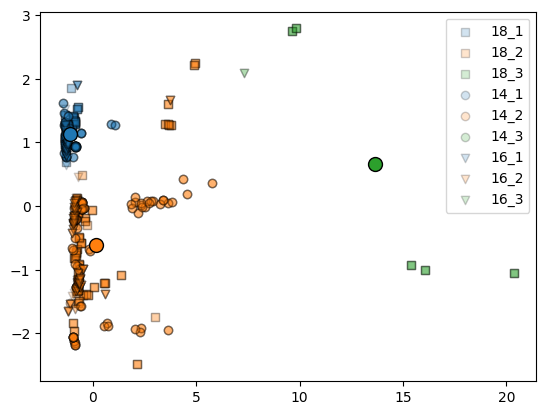

In [19]:
# Create a plot of the first two principle components.
# Clusters are marked by color (blue cluster 1, orange cluster 2 and green cluster 3)
# Space groups are marked by shape (14: circle, 16: triangle, 18: square)

sg_markers = {14:"o",16:"v",18:"s"}

for sg in pd_node['Space Group'].unique():
    for i in range(3):
        points = pd_node.loc[(pd_node['Space Group'] == sg) & (pd_node['Cluster'] == i)][["PC1","PC2"]]
        plt.scatter(points["PC1"],points["PC2"],label=str(sg)+"_"+str(i+1),alpha=0.20,marker=sg_markers[sg],c=f"C{i}",edgecolors='black')

cluster_centers = kmeans_node.cluster_centers_
centers = PCA_node.transform(pd.DataFrame({f"Atom Feature {i+1}":cluster_centers[:,i] for i in range(64)}))

#Mark centers of the clusters.
for i in range(3):
    plt.scatter(centers[i][0],centers[i][1],c=f"C{i}",s=100,edgecolors='black')

        
plt.legend()
plt.show()

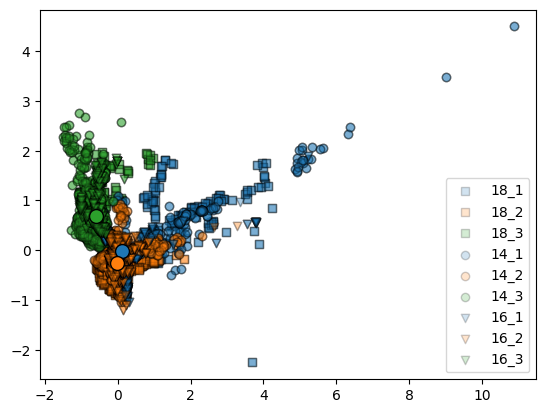

In [158]:
# Create a plot of the first two principle components.
# Clusters are marked by color (blue cluster 1, orange cluster 2 and green cluster 3)
# Space groups are marked by shape (14: circle, 16: triangle, 18: square)

sg_markers = {14:"o",16:"v",18:"s"}

for sg in pd_edge['Space Group'].unique():
    for i in range(3):
        points = pd_edge.loc[(pd_edge['Space Group'] == sg) & (pd_edge['Cluster'] == i)][["PC1","PC2"]]
        plt.scatter(points["PC1"],points["PC2"],label=str(sg)+"_"+str(i+1),alpha=0.20,marker=sg_markers[sg],c=f"C{i}",edgecolors='black')

cluster_centers = kmeans_edge.cluster_centers_
centers = PCA_edge.transform(pd.DataFrame({f"Bond Feature {i+1}":cluster_centers[:,i] for i in range(64)}))
        
for i in range(3):
    plt.scatter(centers[i][0],centers[i][1],c=f"C{i}",s=100,edgecolors='black')

        
plt.legend()
plt.show()

# Plot on atom type

28


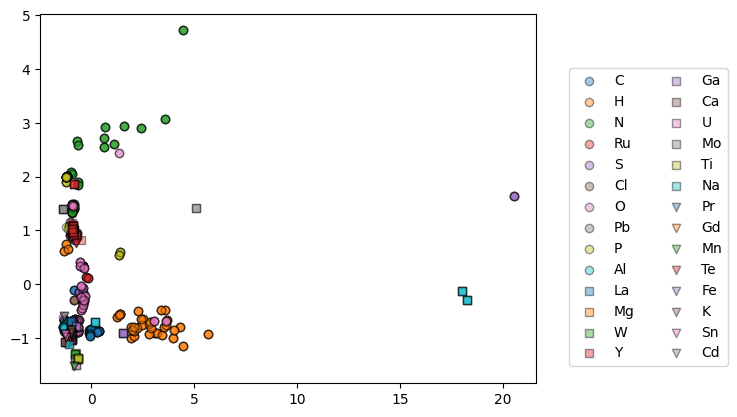

In [156]:
# Annotate me

n_species = len(pd_node['Species'].unique())

print(n_species)
marker = "o"


for i in range(n_species):
    
    specie = pd_node['Species'].unique()[i]
    
    if i > 9:
        marker = "s"
    if i > 19:
        marker = "v"
    
    points = pd_node.loc[pd_node['Species'] == specie][["PC1","PC2"]]
    plt.scatter(points["PC1"],points["PC2"],label=specie,alpha=0.40,marker=marker,edgecolor="black")
        
plt.legend(ncol=2,loc=5,bbox_to_anchor=(0.9, 0.2, 0.5, 0.5))
plt.show()